# Dataset exploration

In [107]:
import os
import json

get_data_from_dir = lambda dir: [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.json')]

locations = ["mandrac_imgs1", "mandrac_imgs2", "bistrina_imgs"]
datasets = [get_data_from_dir(f"data/{loc}") for loc in locations]

# they did train – mandrac1, val – mandrac2, test – bistrina

# To form the training,
# validation and test sets, we first create collections A, B and
# C by sampling the videos from the first, second and third
# acquisition, respectively. From approximately 15 minutes
# of a video, we sample only 162 images to ensure there
# are no duplicate images. Also, to make the dataset more
# challenging, we use only collection A for training. The
# validation and test sets are formed from collections B and C (see Fig. 3.)

datasets_positives = []
for dataset in datasets:
    dataset_positives = 0
    for img_json in dataset:
        # json_path = os.path.splitext(datasets[0][0])[0]  + ".json"
        with open(img_json) as json_file:
            data = json.load(json_file)
            for shape in data["shapes"]:
                if shape["label"] == "trash":
                    dataset_positives += 1
                else:
                    print("negative example found in", img_json)
    print(dataset_positives)
        
    datasets_positives.append(dataset_positives)

all = sum([len(d) for d in datasets])
for i in range(len(locations)):
    print(f"{locations[i]}: {len(datasets[i])} images ({len(datasets[i])/all*100:.2f}%), {datasets_positives[i]} positive examples")

# no negative examples in the dataset

34
101
119
mandrac_imgs1: 34 images (19.32%), 34 positive examples
mandrac_imgs2: 62 images (35.23%), 101 positive examples
bistrina_imgs: 80 images (45.45%), 119 positive examples


In [108]:
import os
import json

get_data_from_dir = lambda dir: [os.path.join(dir, f) for f in os.listdir(dir) if f.endswith('.json')]

locations = ["training", "validation", "test"]
datasets = [get_data_from_dir(f"data/Dataset/{loc}") for loc in locations]

datasets_positives = []
for dataset in datasets:
    dataset_positives = 0
    for img_json in dataset:
        # json_path = os.path.splitext(datasets[0][0])[0]  + ".json"
        with open(img_json) as json_file:
            data = json.load(json_file)
            for shape in data["shapes"]:
                if shape["label"] == "trash":
                    dataset_positives += 1
                else:
                    print("negative example found in", img_json)
        
    datasets_positives.append(dataset_positives)

all = sum([len(d) for d in datasets])
for i in range(len(locations)):
    print(f"{locations[i]}: {len(datasets[i])} images ({len(datasets[i])/all*100:.2f}%), {datasets_positives[i]} positive examples")

# no negative examples in the dataset

training: 20 images (12.35%), 20 positive examples
validation: 20 images (12.35%), 36 positive examples
test: 122 images (75.31%), 184 positive examples


### Crafting features

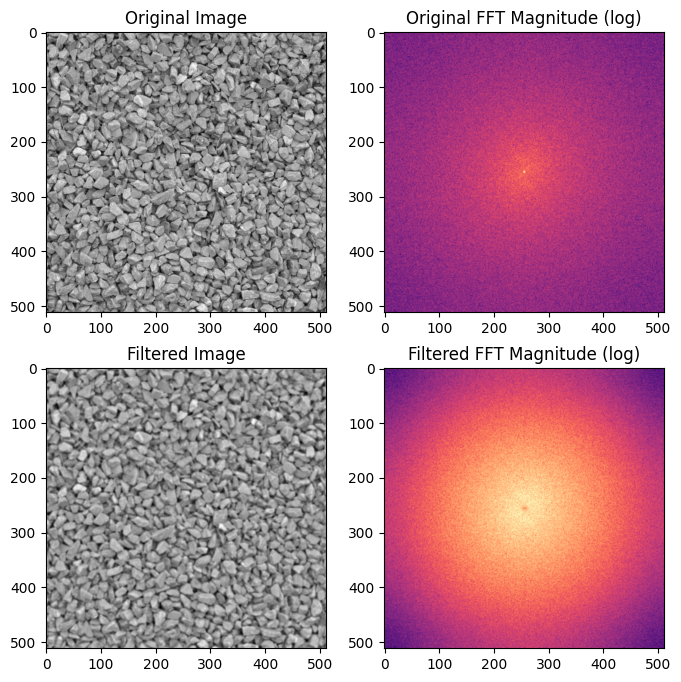

In [109]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.data import gravel
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift

image = gravel()
wimage = image * window('hann', image.shape)  # window image to improve FFT
filtered_image = difference_of_gaussians(image, 1, 12)
filtered_wimage = filtered_image * window('hann', image.shape)
im_f_mag = fftshift(np.abs(fftn(wimage)))
fim_f_mag = fftshift(np.abs(fftn(filtered_wimage)))

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(np.log(im_f_mag), cmap='magma')
ax[0, 1].set_title('Original FFT Magnitude (log)')
ax[1, 0].imshow(filtered_image, cmap='gray')
ax[1, 0].set_title('Filtered Image')
ax[1, 1].imshow(np.log(fim_f_mag), cmap='magma')
ax[1, 1].set_title('Filtered FFT Magnitude (log)')
plt.show()

del filtered_image, filtered_wimage, im_f_mag, fim_f_mag


Diffrence of gausian 
- applying gussian blure with some defition to blurred image 
- the same with some scaller for difation 
- dwa zblurowane zdjęcia z czego jedno jest bardziej zblurowane od grugiego 
- odejmujemy te dwa zdjęcia i mamy edge lines 
- (potem można binaryzacje z jakimś treschold)
- czyli wykrywa miejsca o wysokim kontraście które z reguły są wierzchołami/liniami 
- problem z tym że też wykrywa noise 

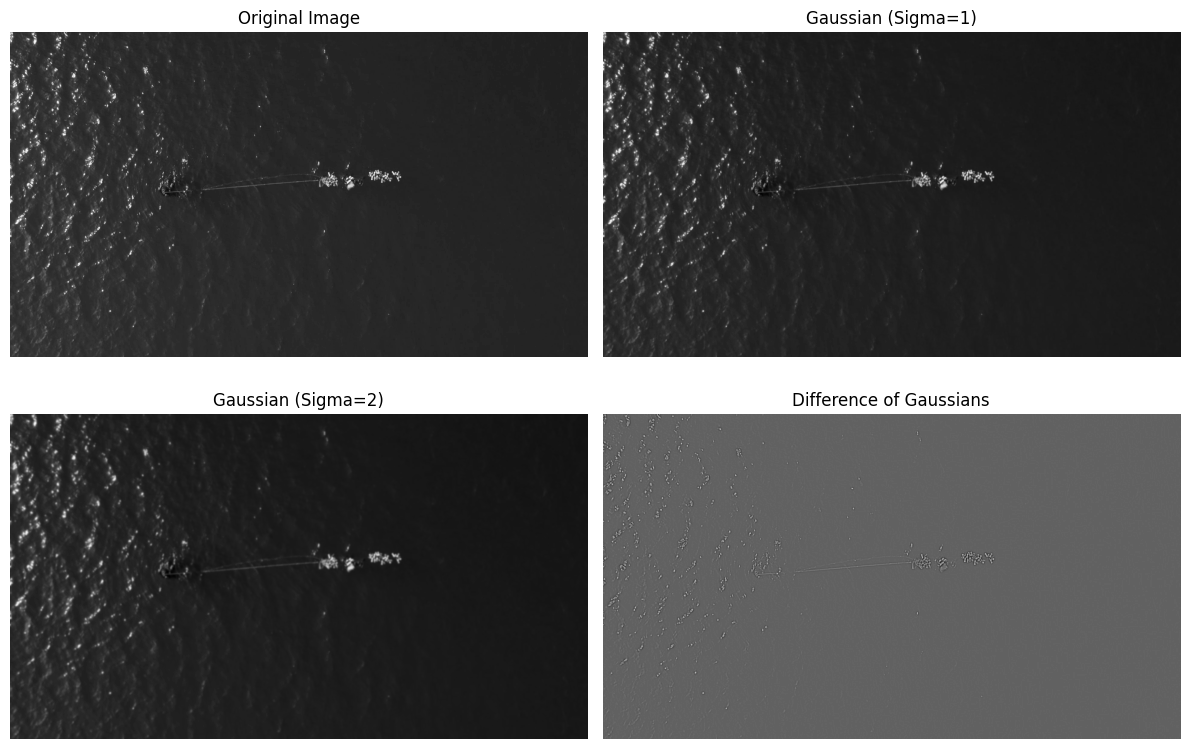

In [110]:
import matplotlib.pyplot as plt
from skimage import io, color, img_as_float
from skimage.filters import gaussian, difference_of_gaussians

image = io.imread('data/bistrina_imgs/record4_102_19.JPG')

gray_image = color.rgb2gray(image)

# Step 3: Convert the image to float format
float_image = img_as_float(gray_image)

# Step 4: Apply Gaussian blurring with different sigma values
sigma1 = 1  # Sigma value for the first Gaussian blur
sigma2 = 2  # Sigma value for the second Gaussian blur
gaussian1 = gaussian(float_image, sigma=sigma1)
gaussian2 = gaussian(float_image, sigma=sigma2)

# Step 5: Compute the difference of Gaussians
dog_image = difference_of_gaussians(float_image, sigma1, sigma2)

# Step 6: Display the original image, Gaussian blurred images, and the difference of Gaussians
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Changed figsize to accommodate two rows
ax = axes.ravel()

ax[0].imshow(float_image, cmap='gray')
ax[0].set_title('Original Image')

ax[1].imshow(gaussian1, cmap='gray')
ax[1].set_title('Gaussian (Sigma={})'.format(sigma1))

ax[2].imshow(gaussian2, cmap='gray')
ax[2].set_title('Gaussian (Sigma={})'.format(sigma2))

ax[3].imshow(dog_image, cmap='gray')
ax[3].set_title('Difference of Gaussians')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()

del float_image, gaussian1, gaussian2, dog_image


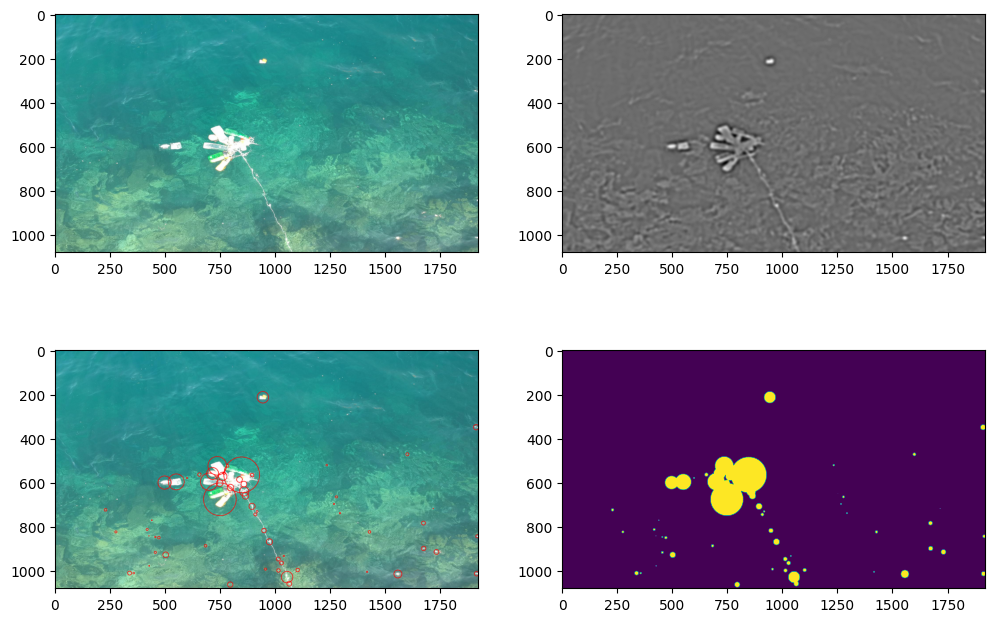

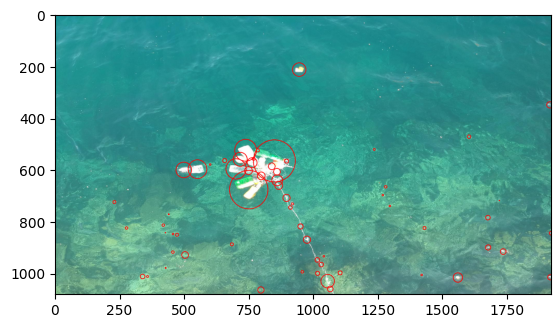

In [111]:
import os
import cv2

def get_sigma(altitude):
    if altitude <= 5:
        sigma = 6
    elif altitude <= 10:
        sigma = 5
    elif altitude <= 15:
        sigma = 4
    elif altitude <= 20:
        sigma = 3
    else:
        sigma = 2
    return sigma


path = "data/Dataset/training/"
filename = "train_image1"
image = io.imread(path + filename + ".JPG")

with open(path + filename + ".json") as json_file:
    data = json.load(json_file)
    altitude = int(os.path.splitext(data["imagePath"])[0].split('_')[-1])

### Apply difference of gaussians
sigma = get_sigma(altitude)

gray_image = color.rgb2gray(image)
float_image = img_as_float(gray_image)

dog_image = difference_of_gaussians(float_image, sigma, 1.6*sigma)

threshold = 0.03

mask = dog_image.copy()
_, mask = cv2.threshold(mask, threshold, 1, cv2.THRESH_BINARY)
mask = mask.astype(np.uint8)

### Find ROIs
contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = image.copy()
black = np.zeros_like(mask)

rois = []
circles = []
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)

    # Draw the circle around the ROI
    scaling_factor = 1.5 # increase the size of the circle for merging the ROIs
    center = (x + w // 2, y + h // 2)
    radius = int(scaling_factor * max(w, h) / 2)
    cv2.circle(image_with_contours, center, radius, (255, 0, 0), 2)
    cv2.circle(black, center, radius, (255, 0, 0), -1)
    circles.append((*center, radius))
    
    # cv2.rectangle(image_with_contours, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # Add ROI to the list
    roi_image = image[y:y+h, x:x+w]
    rois.append(roi_image)

### Merge ROIs

fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Changed figsize to accommodate two rows
ax = axes.ravel()
ax[0].imshow(image)
ax[1].imshow(dog_image, cmap='gray')
ax[2].imshow(image_with_contours)
ax[3].imshow(black)
plt.show()

plt.imshow(image_with_contours)

del gray_image, float_image, dog_image, mask, contours, image_with_contours, black, rois, roi_image



In [112]:
old_circles = circles.copy()

In [113]:
circles = old_circles.copy()
len(circles)

63

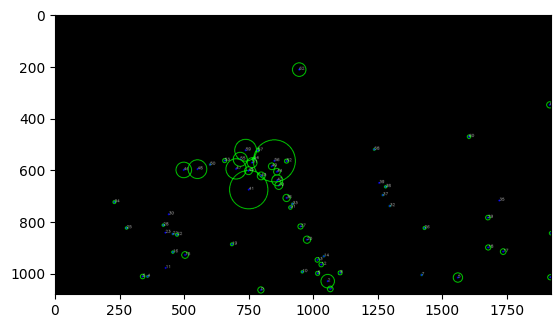

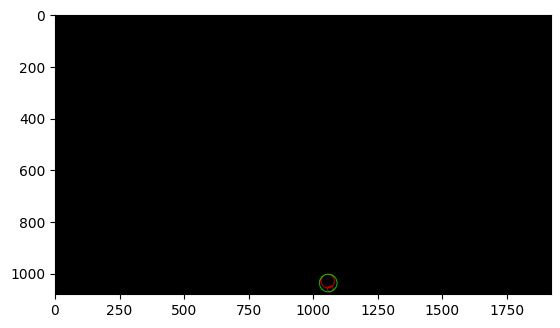

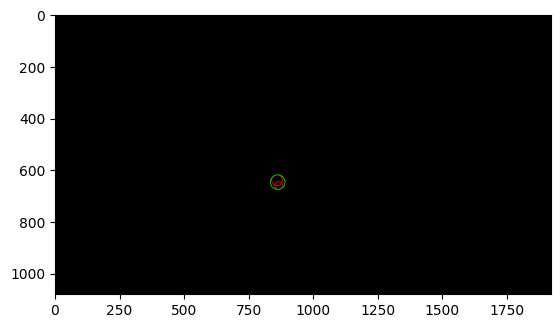

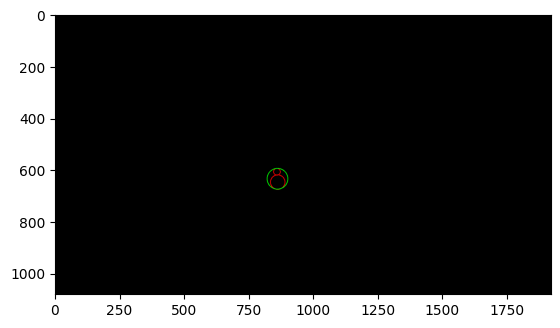

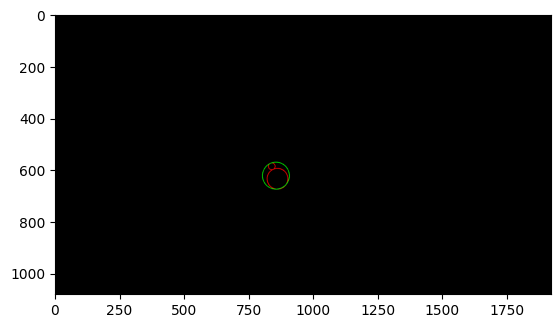

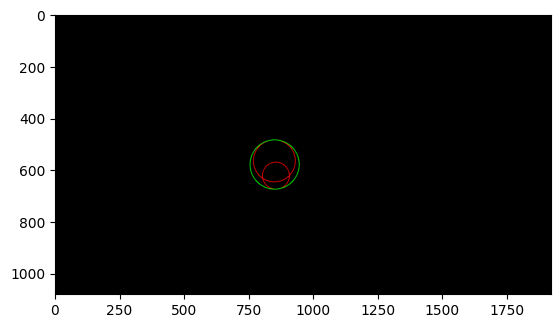

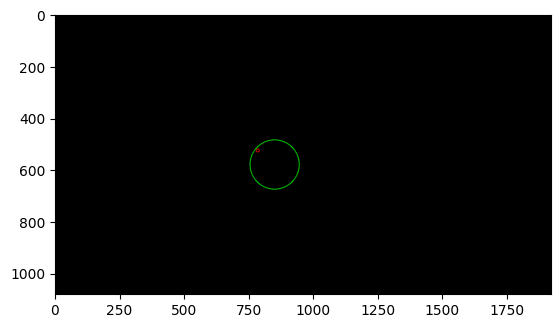

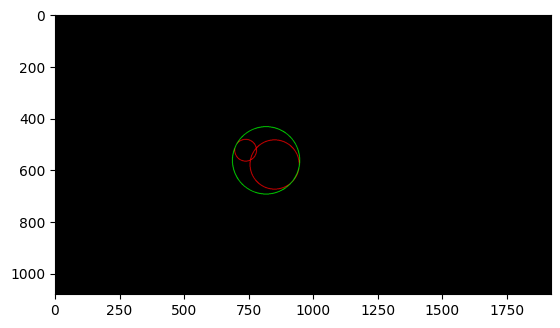

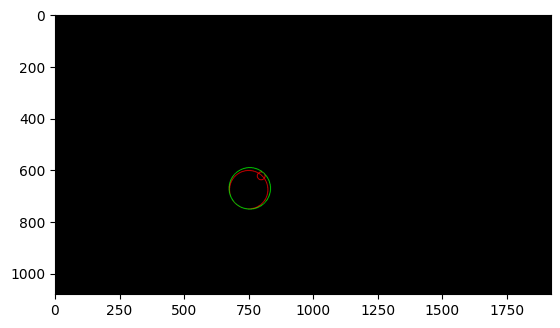

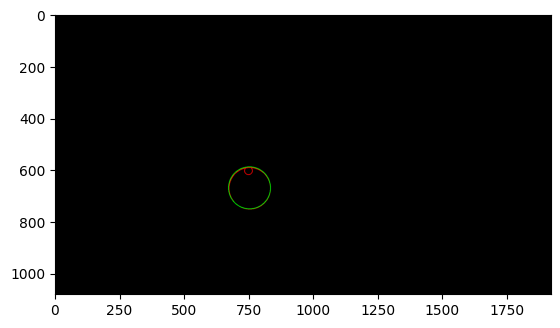

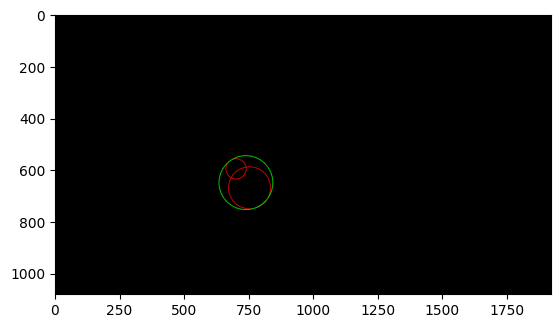

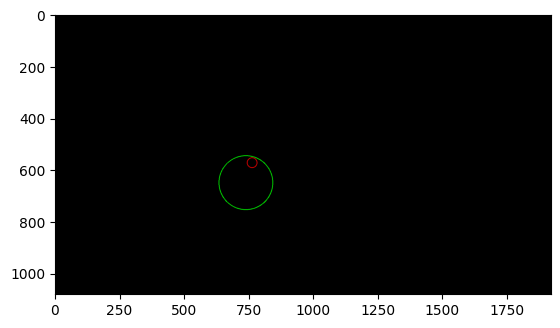

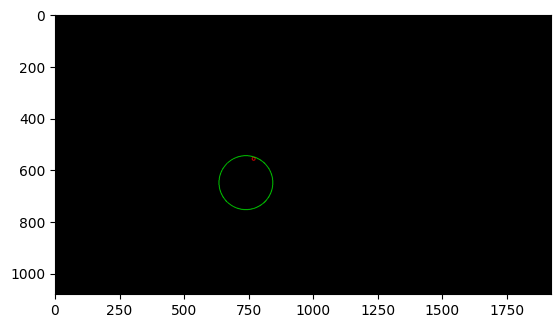

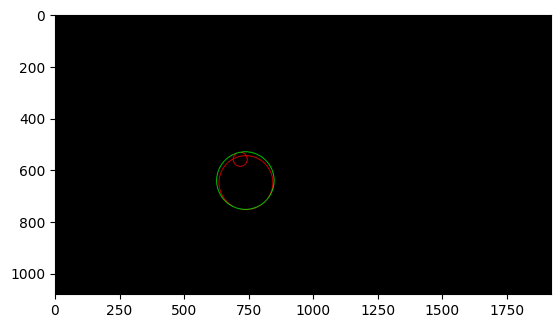

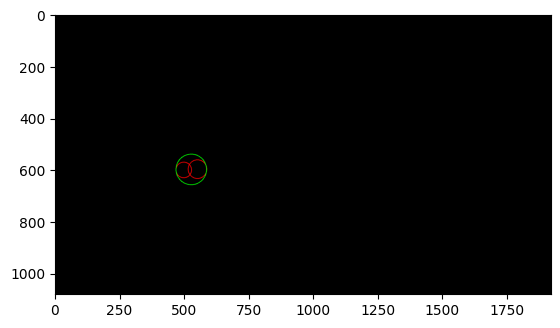

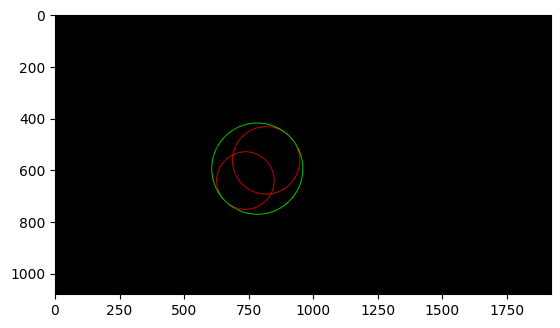

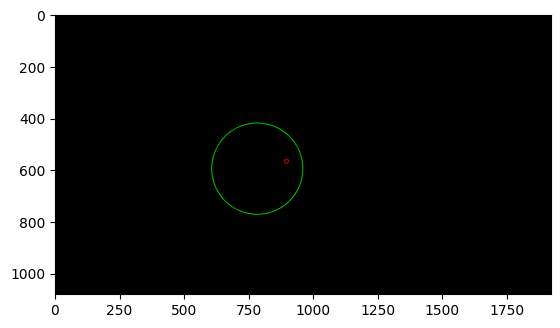

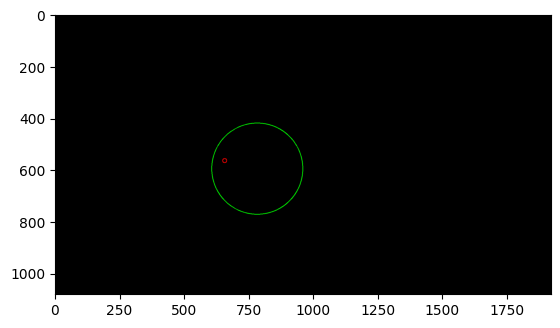

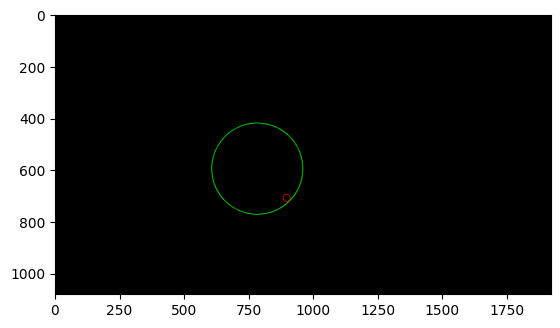

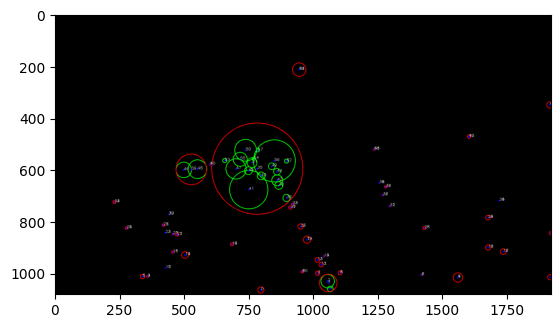

In [114]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sympy import symbols, Eq, solve


def show_circles(circles, color):
    for i, circle in enumerate(circles):
        x, y, r = circle
        cv2.circle(image, (x, y), r, color, 2)
        cv2.circle(image, (x, y), 2, (0, 0, 255), 3)  # Center
        cv2.putText(image, f"{i}", (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    plt.imshow(image);
    plt.show()

def circles_intersect(circle1, circle2):
    # Check if two circles intersect
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    dist_centers = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return dist_centers <= (r1 + r2), dist_centers

def circle_in_circle(circle1, circle2, dist_centers):
    # Check if circle1 is inside circle2
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2
    if dist_centers + r2 <= r1:
        return circle1
    if dist_centers + r1 <= r2:
        return circle2
    else:
        return False
    
def find_new_center(circle1, circle2):
    x1, y1, r1 = circle1
    x2, y2, r2 = circle2

    # Symbole
    x, y = symbols('x y')

    # Prosta przechodząca przez 2 punkty
    m = (y2 - y1) / (x2 - x1)
    line_eq = Eq(y - y1, m*(x - x1))

    # Równanie okręgu: (x - a)^2 + (y - b)^2 = r^2
    circle_eq1 = Eq((x - x1)**2 + (y - y1)**2, r1**2)
    circle_eq2 = Eq((x - x2)**2 + (y - y2)**2, r2**2)

    # Rozwiązanie równań
    solutions1 = solve((line_eq, circle_eq1), (x, y))
    solutions2 = solve((line_eq, circle_eq2), (x, y))
    solutions = solutions1 + solutions2

    solutions.sort(key=lambda p: p[0] + p[1])

    x = (solutions[0][0] + solutions[-1][0])//2
    y = (solutions[0][1] + solutions[-1][1])//2

    return (int(x), int(y))
   


def show_merge(image, center1, r1, center2, r2, new_center, new_radius):
    blank = np.zeros_like(image)

    cv2.circle(blank, center1, r1, (255, 0, 0), 2)
    cv2.circle(blank, center2, r2, (255, 0, 0), 2)
    cv2.circle(blank, new_center, new_radius, (0, 255, 0), 2)
    plt.imshow(blank);
    plt.show()


# Create a black image
image = np.zeros_like(image)
# image = np.zeros((300, 400, 3), dtype=np.uint8)

# Initialize the list of circles
# circles = [
#     (130, 140, 20),
#     (150, 150, 30),
#     (150, 175, 25),
#     (300, 100, 35),
#     (310, 110, 10)
# ]
show_circles(circles, (0, 255, 0))


# Greedy grouping algorithm to merge intersecting circles
changed = True
while changed == True:
    changed = False
    i = 0
    while i < len(circles):
            j = i + 1
            while j < len(circles):
                intersect, distance = circles_intersect(circles[i], circles[j])
                x1, y1, r1 = circles[i]
                x2, y2, r2 = circles[j]
                if intersect:
                    # Merge circles[i] and circles[j]
                    if circle:= circle_in_circle(circles[i], circles[j], distance):
                        new_x, new_y, new_radius = circle
                    else:
                        new_radius = int((r1 + r2 + distance)//2)
                        new_x, new_y = find_new_center(circles[i], circles[j])
                    
                    # show_merge(image, (x1, y1), r1, (x2, y2), r2, (new_x, new_y), new_radius)
                    circles[i] = (new_x, new_y, new_radius)
                    circles.pop(j)
                    changed = True

                else:
                    j+=1
            i += 1
                    
# Draw circles around the final merged circles
show_circles(circles, (255, 0 , 0))


 SIFT descriptor to create gradient histograms
 HOG 
 - feture extraction 
 - 

In [118]:
from skimage.feature import hog
from skimage import exposure


fd, hog_image = hog(dog_image, visualize=True, block_norm='L2-Hys')

# fd, hog_image = hog(dog_image, orientations=8, pixels_per_cell=(16, 16),
                    # cells_per_block=(1, 1), visualize=True, channel_axis=-1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharex=True, sharey=True)

ax1.axis('off')
ax1.imshow(dog_image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

NameError: name 'dog_image' is not defined

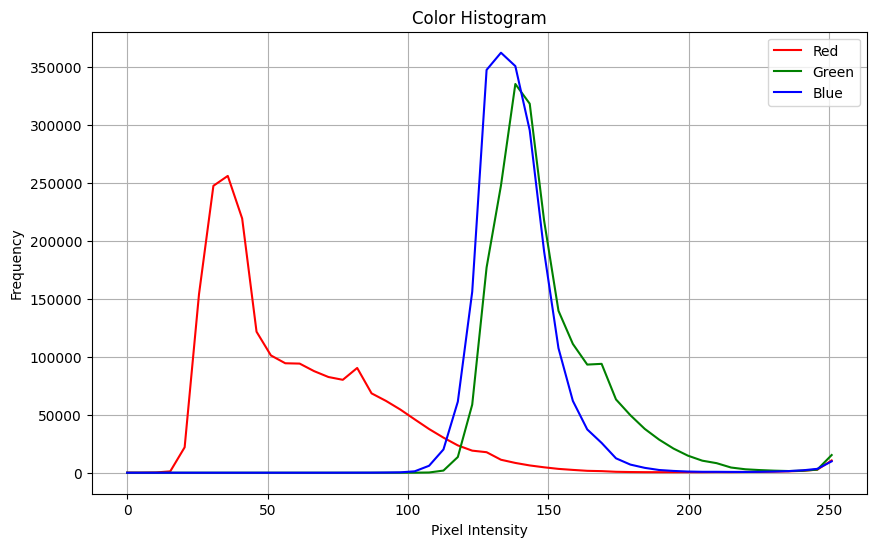

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from skimage import io

# Step 1: Read the input image
image = io.imread('Dataset/training/train_image1.JPG')

# Step 2: Compute color histograms for each channel (R, G, B)
hist_r, bins_r = np.histogram(image[:, :, 0], bins=50, range=(0, 256))
hist_g, bins_g = np.histogram(image[:, :, 1], bins=50, range=(0, 256))
hist_b, bins_b = np.histogram(image[:, :, 2], bins=50, range=(0, 256))

# Step 3: Plot the color histograms
plt.figure(figsize=(10, 6))
plt.plot(bins_r[:-1], hist_r, color='r', label='Red')
plt.plot(bins_g[:-1], hist_g, color='g', label='Green')
plt.plot(bins_b[:-1], hist_b, color='b', label='Blue')
plt.title('Color Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()
